# Transfer Learning Part 3 - Scaling Up

In [1]:
#IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# get input data images
from tensorflow.keras.utils import image_dataset_from_directory

# import layers
from tensorflow.keras import layers

# data augmentation imports
from tensorflow.keras.layers.experimental import preprocessing

In [20]:
!nvidia-smi

Wed Nov  3 07:50:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   2290MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# get our helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-03 07:42:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-03 07:42:56 (48.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import plot_loss_curves, create_tensorboard_callback, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix, load_and_prep_image

## 101 Food classes - import the data

In [5]:
#download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-11-03 07:42:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   190MB/s    in 8.3s    

2021-11-03 07:43:06 (186 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
#unzip the data
unzip_data('101_food_classes_10_percent.zip')

In [7]:
# set the directory paths
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [8]:
# walk through our directory
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '

In [9]:
# setup variables
IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [10]:
# setup data inputs
train_data_10_percent = image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

test_data = image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train our big dog model - feature extraction transfer learning model + fine tuning later

### Create model checkpoint

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='ModelCheckpoints/Checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True
)

### Create data augmentation layer

In [11]:
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal',input_shape=IMG_SIZE+(3,)),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
],name='data_augmentation')

### Create a headless EfficientNet Model with Data Augementation build in

In [12]:
# create the input layer
inputs = tf.keras.Input(shape=IMG_SIZE+(3,),name='input_layer')

# pass the input layer through the data augmentation layer
# x = data_augmentation(inputs)

# create the base_model = efficientnet model b0
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE+(3,)
)

# set the layers to not being trainable
base_model.trainable=False

# pass the data augmented inputs through the model
# freeze the batchnorm layers with training=False
x = base_model(inputs,training=False)

# create the GlobalAvgPooling Layer and pass it the model outputs
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)

# outputs of the model
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names),activation='sigmoid')(x)

16719872/16705208 [==============================] - 0s 0us/step


### Construct and compile the model

In [13]:
# construct the model
model = tf.keras.Model(inputs, outputs)

In [14]:
# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'    
)

In [15]:
# get a model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_avg_pooling_layer (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
for layer in model.layers:
  print(layer.name, '----',layer.trainable)

input_layer ---- True
efficientnetb0 ---- False
global_avg_pooling_layer ---- True
dense ---- True


### Fit the model

In [17]:
initial_epochs=5

In [19]:
# fit the model
history_model_1 = model.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
)

Epoch 1/5
237/237 [==============================] - 32s 134ms/step - loss: 3.1354 - accuracy: 0.3216
Epoch 2/5
237/237 [==============================] - 32s 131ms/step - loss: 1.8557 - accuracy: 0.5823
Epoch 3/5
237/237 [==============================] - 32s 131ms/step - loss: 1.4464 - accuracy: 0.6651
Epoch 4/5
237/237 [==============================] - 31s 130ms/step - loss: 1.2022 - accuracy: 0.7286
Epoch 5/5
237/237 [==============================] - 31s 130ms/step - loss: 1.0231 - accuracy: 0.7790


### Evaluate the model results

In [ ]:
# evaluate on the full test dataset
model.evaluate(test_data)

790/790 [==============================] - 109s 138ms/step - loss: 1.7233 - accuracy: 0.5534


[1.7233377695083618, 0.5533861517906189]

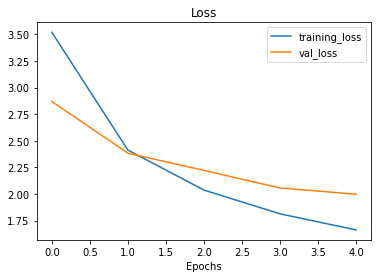

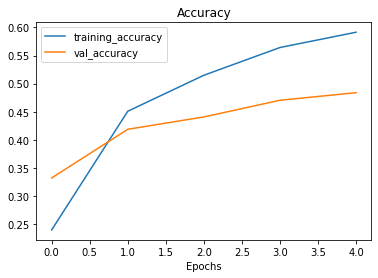

In [ ]:
# plot loss curves
plot_loss_curves(history_model_1)

### FineTuning of the Model

In [ ]:
for layer in model.layers:
  print(layer.name,'----',layer.trainable)

input_layer ---- True
data_augmentation ---- True
efficientnetb0 ---- False
global_avg_pooling_layer ---- True
dense_5 ---- True


In [ ]:
# set the base model to trainable 
base_model.trainable=True

In [ ]:
# only let the last 5 layers be trainable
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'    
)

In [ ]:
for layer in model.layers:
  print(layer.name,'----',layer.trainable)

input_layer ---- True
data_augmentation ---- True
efficientnetb0 ---- True
global_avg_pooling_layer ---- True
dense_5 ---- True


### Fit the fine tuned model

In [ ]:
total_epochs=initial_epochs+5

In [ ]:
history_model_1_finetuned = model.fit(
    train_data_10_percent,
    epochs=total_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[
      model_checkpoint
    ],
    initial_epoch=initial_epochs
)

Epoch 6/10
237/237 [==============================] - 91s 348ms/step - loss: 1.4150 - accuracy: 0.6364 - val_loss: 1.9437 - val_accuracy: 0.4928
Epoch 7/10
237/237 [==============================] - 77s 323ms/step - loss: 1.3004 - accuracy: 0.6560 - val_loss: 1.9250 - val_accuracy: 0.5021
Epoch 8/10
237/237 [==============================] - 74s 311ms/step - loss: 1.2058 - accuracy: 0.6797 - val_loss: 1.9137 - val_accuracy: 0.5037
Epoch 9/10
237/237 [==============================] - 74s 310ms/step - loss: 1.1492 - accuracy: 0.6964 - val_loss: 1.9049 - val_accuracy: 0.5077
Epoch 10/10
237/237 [==============================] - 70s 295ms/step - loss: 1.0764 - accuracy: 0.7156 - val_loss: 1.9423 - val_accuracy: 0.4944


### Evaluate on the test dataset

In [ ]:
# Evaluate on the full test dataset
model.evaluate(test_data)

790/790 [==============================] - 109s 137ms/step - loss: 1.6081 - accuracy: 0.5740


[1.6080657243728638, 0.5739802122116089]

## Evaluate the performace of the model across all classes

In [ ]:
import tensorflow as tf

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-11-02 07:29:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 209.85.200.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   151MB/s    in 0.3s    

2021-11-02 07:29:37 (151 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

### load in the model

In [ ]:
# load in the saved model
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 101)               129381    
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
# evaluate the model on the test data
model.evaluate(test_data)

790/790 [==============================] - 133s 130ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [ ]:
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 89s 110ms/step


In [ ]:
preds_classes = preds_probs.argmax(axis=1)

In [ ]:
# how many batches do we have
len(test_data)

790

In [ ]:
# get a single prediction
np.round(preds_probs[0],2)

array([0.06, 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.85, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ], dtype=float32)

In [ ]:
# get the ground truth labels
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # use argmax to get the argmax of the onehot encoded labels

In [ ]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
preds_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(
    y_labels,
    preds_classes
)
sklearn_accuracy

0.6077623762376237

### Lets get visual - plot confusion matrix

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # rotate the labels and increase font_size
  ax.set_xticklabels(labels,rotation=75,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


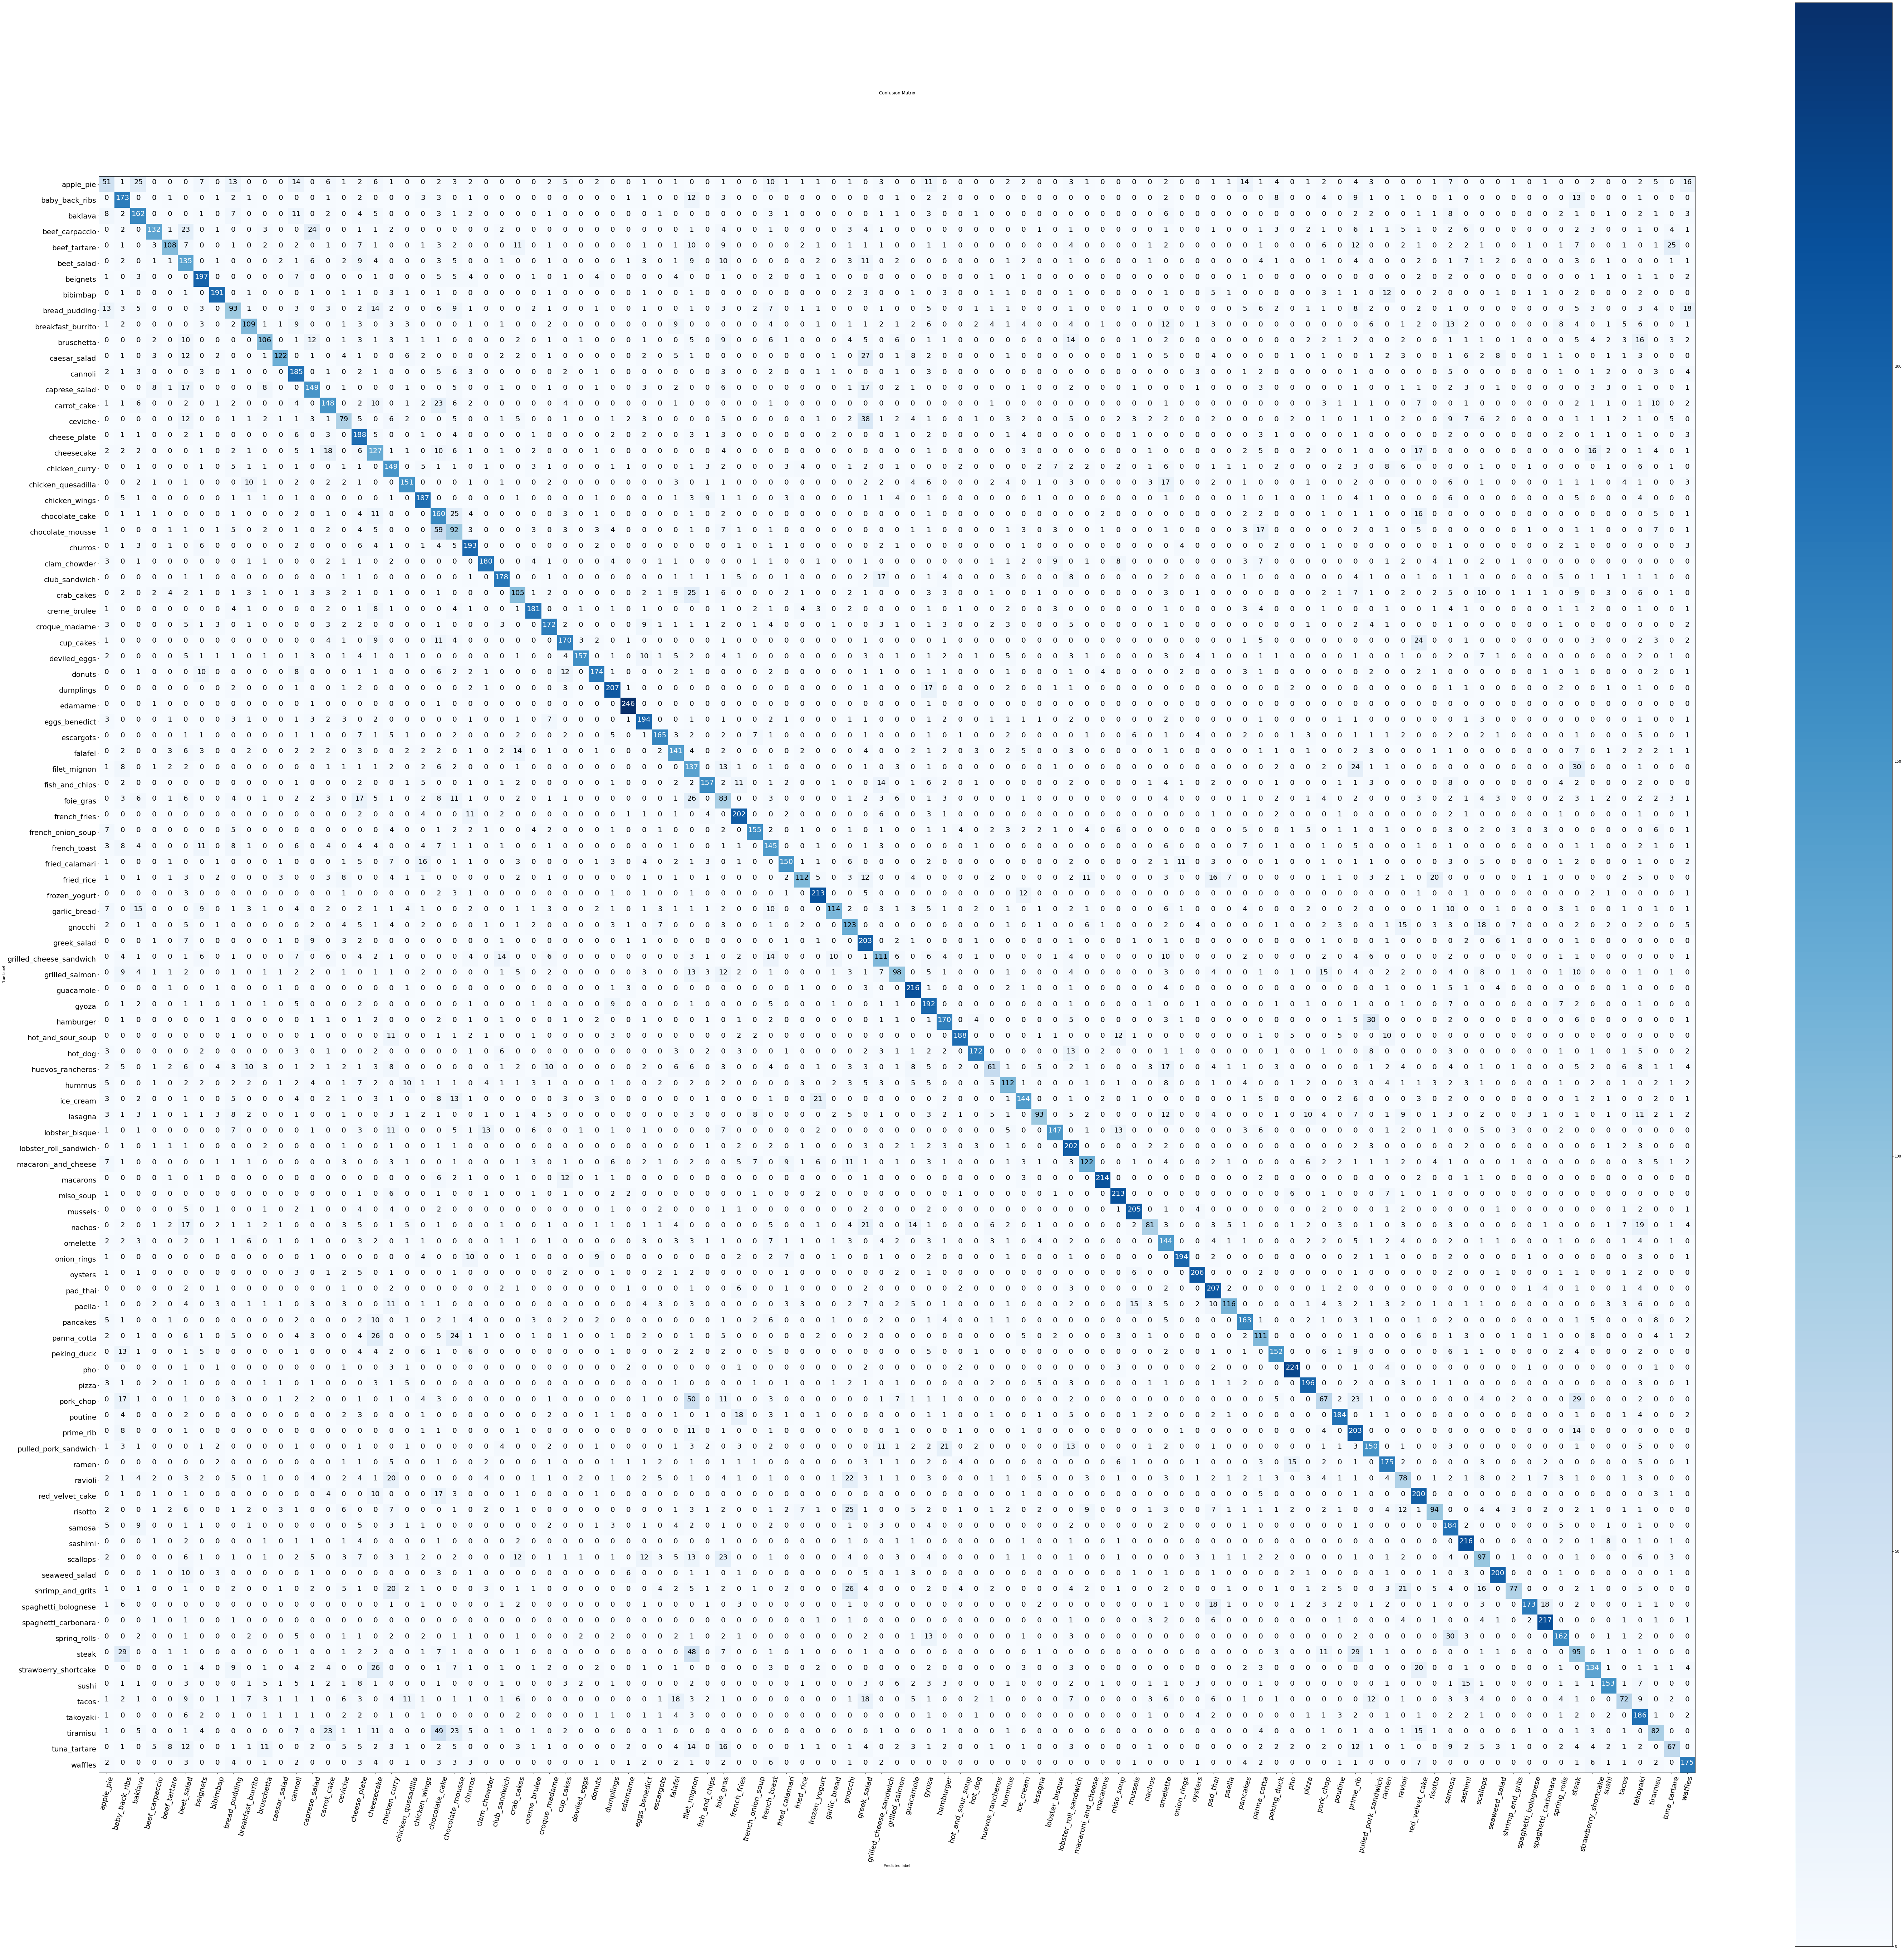

In [ ]:
make_confusion_matrix(
    y_labels,
    preds_classes,
    classes=test_data.class_names,
    figsize=(100,100),
    text_size=20
)

### Time for classification report - further evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
dict_cr = classification_report(
    y_labels,
    preds_classes,
    target_names=test_data.class_names,
    output_dict=True
)

In [ ]:
dict_cr[test_data.class_names[0]]#['f1-score']

{'f1-score': 0.24056603773584903,
 'precision': 0.29310344827586204,
 'recall': 0.204,
 'support': 250}

In [ ]:
f1_scores = {}
for label in test_data.class_names:
  f1_scores[label] = dict_cr[label]['f1-score']

In [ ]:
df_f1 = pd.DataFrame(
    {
        'class_names': list(f1_scores.keys()),
        'f1_score': list(f1_scores.values())
    }
).sort_values(by='f1_score')

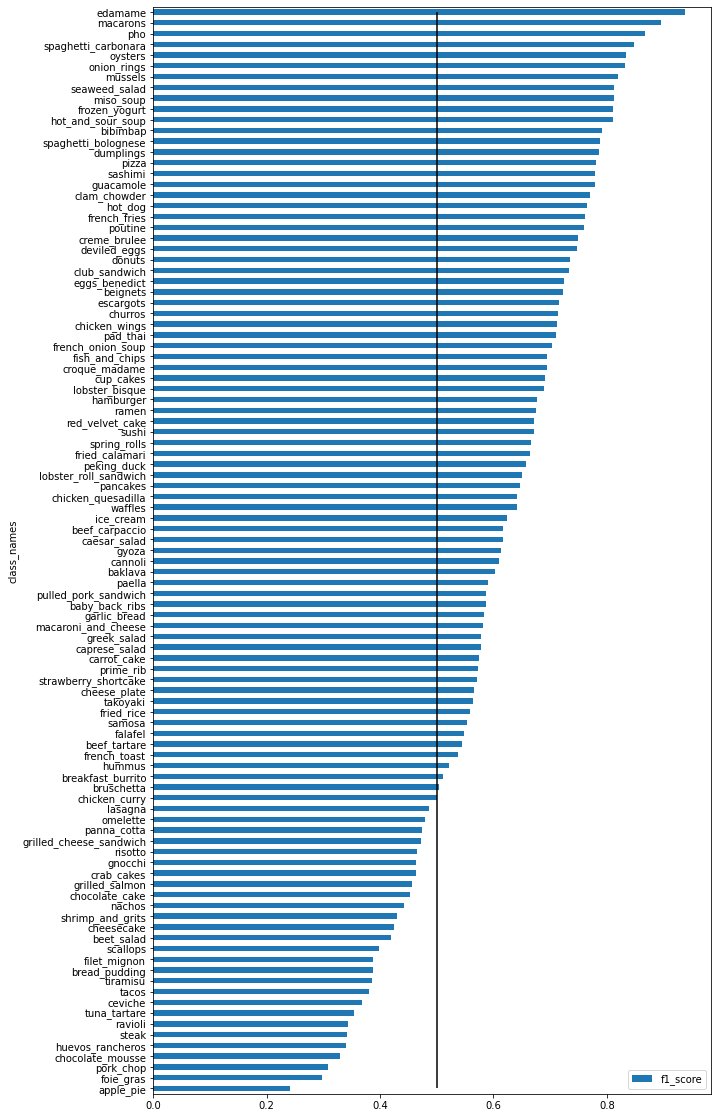

In [ ]:
# create a barplot to visualize the f1 scores per class
df_f1.plot.barh(x='class_names',y='f1_score',figsize=(10,20))
# at least 50 percent f1 score to make it into our app
plt.vlines(0.5,0,100)
plt.show()

#### Check the predicitions with f1-score < 50 percent to see if there are any patterns in the classes

In [ ]:
df_f1_low = df_f1[df_f1.f1_score < 0.5]

In [ ]:
import os
import random
import matplotlib.image as mpimg

test_dir='/content/101_food_classes_10_percent/test'
for class_label, class_name in df_f1_low[['class_names']].iterrows():
  os.chdir(test_dir+'/'+class_name.values[0])
  df = pd.DataFrame({
      'predictions':(np.array(preds_classes))[np.where(np.array(y_labels)==class_label,True,False)],
      'prediction_probs':(np.round(preds_probs.max(axis=1),2))[np.where(np.array(y_labels)==class_label,True,False)]
      })
  pic_index = random.choice(df[df!=class_label].dropna().index)
  img = mpimg.imread(os.listdir()[pic_index])
  imgplot = plt.imshow(img)
  pred_class = test_data.class_names[int(df.loc[pic_index].values[0])]
  pred_prob = df.loc[pic_index].values[1]
  plt.title(f'Image from class {class_name.values[0]} was predicted to be class {pred_class} with probability {np.round(pred_prob*100,2)}%',color='red')
  plt.axis(False)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Plot the most wrong predictions per class of the test dataset


In [ ]:
# get the image file paths of the test dataset images
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
  filepaths.append(filepath)

In [ ]:
class_names = test_data.class_names

In [ ]:
preds_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [ ]:
# create the df with the filepaths
pred_df = pd.DataFrame({
    'img_path': filepaths,
    'y_true': y_labels,
    'y_pred': preds_classes,
    'pred_conf':preds_probs.max(axis=1),
    'y_true_classname':[class_names[i] for i in y_labels],
    'y_pred_classname':[class_names[i] for i in preds_classes]
})

In [ ]:
pred_df['pred_correct'] = pred_df.y_pred == pred_df.y_true

In [ ]:
pred_df_wrong_top100 = pred_df[pred_df.pred_correct==False].sort_values(by='pred_conf',ascending=False).iloc[:100]

In [ ]:
pred_df_wrong_top100[start_index:start_index+images_to_view]

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,tf.Tensor(b'/content/101_food_classes_10_perce...,87,29,0.999997,scallops,cup_cakes,False
231,tf.Tensor(b'/content/101_food_classes_10_perce...,0,100,0.999995,apple_pie,waffles,False
15359,tf.Tensor(b'/content/101_food_classes_10_perce...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,tf.Tensor(b'/content/101_food_classes_10_perce...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,tf.Tensor(b'/content/101_food_classes_10_perce...,85,92,0.999981,samosa,spring_rolls,False
24540,tf.Tensor(b'/content/101_food_classes_10_perce...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,tf.Tensor(b'/content/101_food_classes_10_perce...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,tf.Tensor(b'/content/101_food_classes_10_perce...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,tf.Tensor(b'/content/101_food_classes_10_perce...,71,65,0.999931,paella,mussels,False
23797,tf.Tensor(b'/content/101_food_classes_10_perce...,95,86,0.999904,sushi,sashimi,False


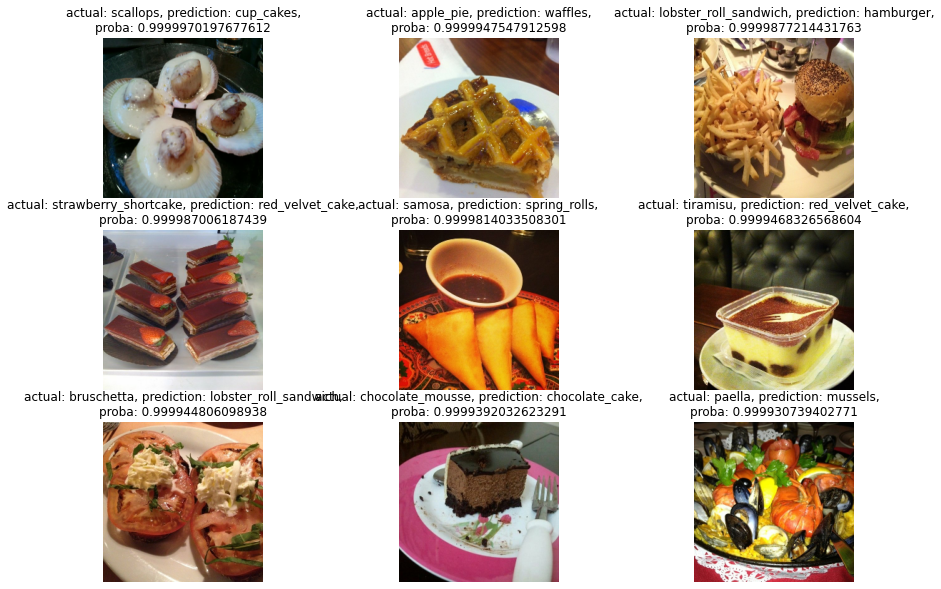

In [ ]:
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(pred_df_wrong_top100[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_prep_image(row[1],scale=False)
  plt.imshow(img/255.)
  _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_ = row
  plt.title(f'actual: {y_true_classname}, prediction: {y_pred_classname},\nproba: {pred_prob}')
  plt.axis(False)